Necessary imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#loading Vgg16 CNN
model = torch.hub.load("pytorch/vision:v0.10.0", "vgg16", pretrained=False)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip<br>
Test Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip<br>
Downloading and extracting testing and training datasets in particular folders


In [ ]:
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
!wget https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
!unzip /content/BelgiumTSC_Training.zip
!unzip /content/BelgiumTSC_Testing.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/00036/01285_00000.ppm  
  inflating: Training/00036/01285_00001.ppm  
  inflating: Training/00036/01285_00002.ppm  
  inflating: Training/00036/01457_00000.ppm  
  inflating: Training/00036/01457_00001.ppm  
  inflating: Training/00036/01457_00002.ppm  
  inflating: Training/00036/01606_00000.ppm  
  inflating: Training/00036/01606_00001.ppm  
  inflating: Training/00036/01606_00002.ppm  
  inflating: Training/00036/01687_00000.ppm  
  inflating: Training/00036/01687_00001.ppm  
  inflating: Training/00036/01687_00002.ppm  
  inflating: Training/00036/GT-00036.csv  
   creating: Training/00037/
  inflating: Training/00037/00099_00000.ppm  
  inflating: Training/00037/00099_00001.ppm  
  inflating: Training/00037/00099_00002.ppm  
  inflating: Training/00037/00100_00000.ppm  
  inflating: Training/00037/00163_00000.ppm  
  inflating: Training/00037/00163_00001.ppm  
  inflating: Training/00037/00163_00002.ppm  
  i

Training and Testing data variables and Loaders

In [ ]:
test_path = "/content/Testing"
train_path = "/content/Training"
batch_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAutocontrast(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

data = torchvision.datasets.ImageFolder(root=train_path, transform=preprocess)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    data, [train_size, test_size]
)


# train_data = torchvision.datasets.ImageFolder(root=train_path,transform=preprocess)
train_dataLoader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0
)
print("Train", len(train_dataset))

test_dataLoader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True, num_workers=0
)
print("Test", len(test_dataset))


Train 3660
Test 915


Hyper Parameters

In [ ]:
num_classes = 62
num_epochs = 30
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

Loass and optimizers

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5) 

Model Training using train_dataLoader

In [ ]:
import time

start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []

steps_list = []
train_loss = []
train_accuracy = []
train_loss = []

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataLoader):
        images, labels = data[0].to(device), data[1].to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropogation and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)

        correct = (predicted == labels).sum().item()

        steps = i + 1
        if steps % 10 == 0:
            accuracy = (correct / total) * 100
            accuracy_list.append(accuracy)
            steps_list.append(steps)
            train_loss.append(loss.item())
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%".format(
                    epoch + 1, num_epochs, steps, total_step, loss.item(), accuracy
                )
            )
        scheduler.step()

print(
    "######## Training Finished in {} seconds ###########".format(
        time.time() - start_time
    )
)
print("Accuracy List: ", accuracy_list, "Steps List: ", steps_list)


Epoch [1/30], Step [10/58], Loss: 5.9009, Accuracy: 7.81%
Epoch [1/30], Step [20/58], Loss: 4.1685, Accuracy: 4.69%
Epoch [1/30], Step [30/58], Loss: 3.7015, Accuracy: 12.50%
Epoch [1/30], Step [40/58], Loss: 3.9044, Accuracy: 7.81%
Epoch [1/30], Step [50/58], Loss: 3.8399, Accuracy: 4.69%
Epoch [2/30], Step [10/58], Loss: 3.6000, Accuracy: 6.25%
Epoch [2/30], Step [20/58], Loss: 3.5190, Accuracy: 7.81%
Epoch [2/30], Step [30/58], Loss: 3.5544, Accuracy: 7.81%
Epoch [2/30], Step [40/58], Loss: 3.5482, Accuracy: 9.38%
Epoch [2/30], Step [50/58], Loss: 3.6572, Accuracy: 6.25%
Epoch [3/30], Step [10/58], Loss: 2.9867, Accuracy: 23.44%
Epoch [3/30], Step [20/58], Loss: 3.0046, Accuracy: 21.88%
Epoch [3/30], Step [30/58], Loss: 2.6555, Accuracy: 35.94%
Epoch [3/30], Step [40/58], Loss: 2.4146, Accuracy: 39.06%
Epoch [3/30], Step [50/58], Loss: 2.3965, Accuracy: 39.06%
Epoch [4/30], Step [10/58], Loss: 2.7119, Accuracy: 26.56%
Epoch [4/30], Step [20/58], Loss: 1.9419, Accuracy: 50.00%
Epoch 

Plotting accuracy graph

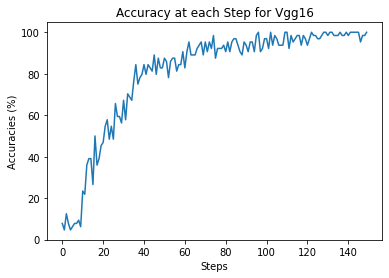

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for Vgg16")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(accuracy_list)

pyplot.show()

Plotting training loss graph

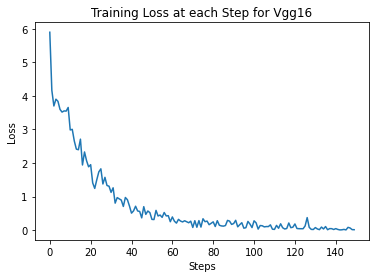

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Training Loss at each Step for Vgg16")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss")
pyplot.plot(train_loss)

pyplot.show()

In [ ]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
import torch.nn.functional as F

pred_y = []
lable_given_img = []

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)

        for i in pred :
          pred_y.append(i.abs().tolist())
        for i in target :
          lable_given_img.append(i.abs().tolist())

        correct += (pred == target).sum()
        
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

Testing accuracy corresponding to test_dataLoader

In [ ]:
for epoch in range(num_epochs):
  evaluate(test_dataLoader)

<ipython-input-9-33b125f0acf2>:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Validation loss: 0.16869	Accuracy: 95.95629119873047 %

Average Validation loss: 0.16446	Accuracy: 96.50273895263672 %

Average Validation loss: 0.21218	Accuracy: 95.30055236816406 %

Average Validation loss: 0.19998	Accuracy: 95.95629119873047 %

Average Validation loss: 0.15848	Accuracy: 96.0655746459961 %

Average Validation loss: 0.16787	Accuracy: 95.1912612915039 %

Average Validation loss: 0.17298	Accuracy: 95.62841796875 %

Average Validation loss: 0.18271	Accuracy: 96.50273895263672 %

Average Validation loss: 0.19367	Accuracy: 95.62841796875 %

Average Validation loss: 0.17341	Accuracy: 95.62841796875 %

Average Validation loss: 0.18102	Accuracy: 95.95629119873047 %

Average Validation loss: 0.17131	Accuracy: 95.08197021484375 %

Average Validation loss: 0.16102	Accuracy: 95.95629119873047 %

Average Validation loss: 0.19228	Accuracy: 95.08197021484375 %

Average Validation loss: 0.17098	Accuracy: 95.62841796875 %

Average Validation loss: 0.20306	Accuracy: 94.9726791

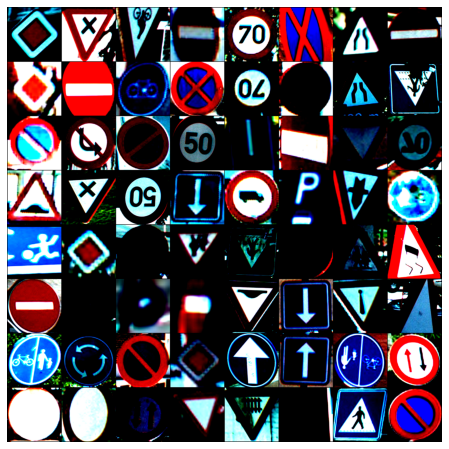

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in test_dataLoader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

Saving Model

In [ ]:
PATH = '/content/Vgg16_BTSD'
torch.save(model.state_dict(), PATH)

Printing Confusion Matrix

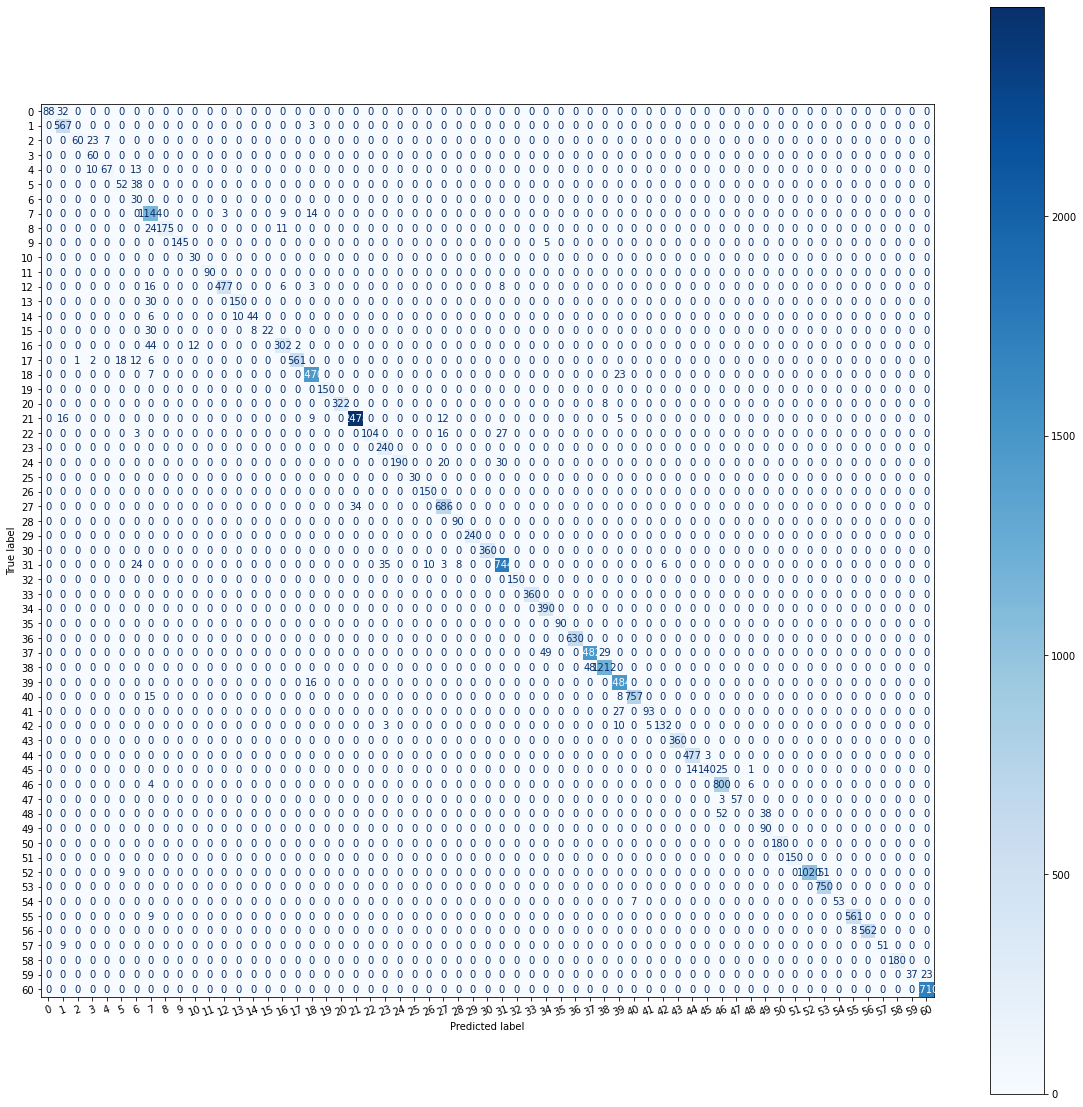

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

numClasses = 62
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, numClasses)
plot_confusion_matrix(lable_given_img, pred_y, labels_arr)

Prinitng Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(lable_given_img, pred_y))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85       120
           1       0.91      0.99      0.95       570
           2       0.98      0.67      0.79        90
           3       0.63      1.00      0.77        60
           4       0.91      0.74      0.82        90
           5       0.66      0.58      0.62        90
           6       0.25      1.00      0.40        30
           7       0.86      0.98      0.91      1170
           8       1.00      0.83      0.91       210
           9       1.00      0.97      0.98       150
          10       0.71      1.00      0.83        30
          12       1.00      1.00      1.00        90
          13       0.99      0.94      0.96       510
          14       0.94      0.83      0.88       180
          15       0.85      0.73      0.79        60
          16       1.00      0.37      0.54        60
          17       0.92      0.84      0.88       360
          18       1.00    